In [1]:
import ibmseti
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import zipfile

from obspy.core import read
from obspy.signal.trigger import classic_sta_lta
from astropy.convolution import convolve, Box1DKernel
from scipy import ndimage

import cv2
%matplotlib inline
import statsmodels.api as sm
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

In [2]:
# Find the data in the zip file
mydatafolder = '../data'
zz = zipfile.ZipFile(os.path.join(mydatafolder, 'basic4.zip'))
basic4list = zz.namelist() #list of all the image files 
firstfile = basic4list[1400] #for testing 

label_csv = pd.read_csv('../data/public_list_basic_v2_26may_2017.csv') #labels for basic4 data 
label_csv.index = label_csv.UUID #make ID the index

In [3]:
def spectrogram_raw(in_file):
    '''
    raw np array of spectrogram 
    '''
    
    # Read data into ibmseti object
    aca = ibmseti.compamp.SimCompamp(zz.open(in_file).read())

    # Get the raw complex data
    complex_data = aca.complex_data()
    complex_data = complex_data.reshape(32, 6144)
    cpfft = np.fft.fftshift( np.fft.fft(complex_data), 1)
    spectrogram = np.abs(cpfft)**2
    
    return spectrogram


def seismogram(in_file):    
    '''
    Sanjoy's Seismogram image processing function 
    Create binary image of highly denoised spectrogram 
    '''
    
    # Read data into ibmseti object
    aca = ibmseti.compamp.SimCompamp(zz.open(in_file).read())

    # Get the raw complex data
    complex_data = aca.complex_data()
    complex_data = complex_data.reshape(32, 6144)
    cpfft = np.fft.fftshift( np.fft.fft(complex_data), 1)
    spectrogram = np.abs(cpfft)**2

    # Create a new empty spectrogram to contain the smooth spedtrogram values
    smoothedspectro=np.zeros(np.shape(spectrogram))

    # Apply seismogram filtering to data
    for i in range(np.shape(spectrogram)[0]):
        background = convolve(spectrogram[i], Box1DKernel(100))
        smoothedspectro[i]=spectrogram[i] - background
        df = 20
        cft = classic_sta_lta(smoothedspectro[i], int(5 * df), int(10 * df))
        indices_ut = np.where(cft>1.7)
        indices_ut = list(indices_ut[0])
        indices_lt = np.where(cft<0.2)
        indices_lt  = list(indices_lt[0])
        indices = indices_ut + indices_lt
        indices_zero = range(0,6144)
        indices_zero = list(set(indices_zero) - set(indices))
        smoothedspectro[i][indices_zero] = 0
        smoothedspectro[i][indices_ut] = 1
        smoothedspectro[i][indices_lt] = 1
        smoothedspectro[i][:500] = 0

    # Binarize the image
    ndimage.binary_erosion(np.asarray(smoothedspectro), structure=np.ones((100,100))).astype(np.int)
    
    return smoothedspectro

# #Plot siesmo spectrogram
# fig, ax = plt.subplots(figsize=(8, 4))
# cmap = plt.cm.get_cmap("binary")
# ax.imshow(spectrogram, cmap=cmap,aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0])
# ax.set_axis_off()

In [338]:
def narrow_linear_fit(image):
    
    '''
    arugments:  the image and a stretch factor
    
    this function applies image processing for smoothing/closing
    it then skeletonizes the image to a line width of one
    these pixel locations are taken and fit to a linear model 
    r^2 is taken to distinguish between narrowband (linear) and narrowbandrd (curved)
    
    returns: linear model object, dependent values for line, independent values for line, spectrogram 
    '''
    
    # IMAGE PROCESSING #
    spectrogram = seismogram(image)
    spectrogram = np.uint8(spectrogram) #prep for openCV 
    kernel = np.ones((11,11),np.uint8) #kernel size for morpho closing 
    spectrogram = cv2.morphologyEx(spectrogram, cv2.MORPH_CLOSE, kernel) #close holes 
    spectrogram = cv2.GaussianBlur(spectrogram, (11,11), 0) #close gaps
    spectrogram[spectrogram > 0] = 255 #make binary
    
    #skeletonize the band, put line loc into curve list 
    def skeletonize(row):
        return np.median(np.array(np.nonzero(row > 0))) 
    curve = []
    curve.append(np.apply_along_axis(skeletonize, 1, spectrogram))
    curve =  np.array(curve).flatten() #convert to numpy for speed 
    curve = curve[~np.isnan(curve)] # get rid of NAN values (where image is blank)
    curve_std = np.std(curve) #standard deviation of curve values
    
    #scale data between 0-~32 (height of raw image, minus the dropped NANs)
    scaler = MinMaxScaler()
    curve = scaler.fit_transform(curve.reshape(-1, 1))
    X = np.linspace((curve.shape[0]-1), 0, curve.shape[0]).flatten()
    curve = curve*X.shape[0] 
    
    #constrain  edges (seemed to cause some issues)
    curve = curve[2:-2] 
    X = X[2:-2]
    
    #fit a linear regression to the skeletonized line
    X = sm.add_constant(X)
    linear_fit = sm.OLS(curve, X).fit() 
    slope, intercept = linear_fit.params

    return linear_fit, curve, X, slope, intercept, curve_std, spectrogram 

In [339]:
plot_ = False #toggle 
data = np.empty((6,)) #for logging values 
index = ['null'] #for logging values 

for i, img_name in enumerate(basic4list): 
    full_label = label_csv.loc[img_name.split('.')[0]] #ID 
    class_ = full_label[1]
    if class_=='narrowbanddrd' or class_=='narrowband':
        index.append(img_name)
        model, line, x, m, b, std, spectrogram  = narrow_linear_fit(img_name) #apply linear function 

        data = np.vstack((data, [class_, model.rsquared, model.rsquared_adj, m, b, std]))  #log for analysis        
#         print class_
#         print result.rsquared, result.rsquared_adj
        
        if plot_ == True:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(7, 7)
            ax1.plot(line, x)
            ax2.imshow(spectrogram, aspect = 10000)
            plt.show()

    progress = i/float(len(basic4list))*100
    if  progress in [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
        print progress, '% completed'
            
results = pd.DataFrame(data=data, columns=['class', 'r2', 'adj_r2', 'slope', 'intercept', 'std'], index=index)

1.0 % completed
10.0 % completed
20.0 % completed
30.0 % completed
40.0 % completed
50.0 % completed
60.0 % completed
70.0 % completed
80.0 % completed
90.0 % completed


# Data prep

In [349]:
# build a data frame of the results 
# only run once!
# results = results[1:] #first row null 
results[[1:]] = results[[1:]].apply(pd.to_numeric) #string to float 
results[['r2', 'adj_r2', 'slope', 'intercept', 'std']] = results[['r2', 'adj_r2', 'slope', 'intercept', 'std']].apply(pd.to_numeric) #string to float 

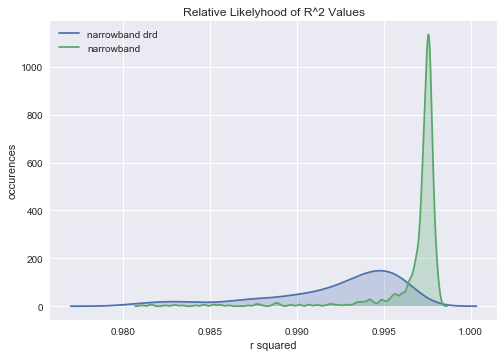

,class,r2,adj_r2,slope,intercept,std
001b4fbd-bfbc-49e0-83a8-8b3c5b8b303d.dat,narrowbanddrd,0.946073,0.943999,30.822459,-1.234244,24.348177
008f5103-bd62-4d4a-b4ba-7a2dcc0ba217.dat,narrowband,0.997530,0.997435,-3.185448,1.236958,61.930751
009f6e84-1a0b-4b62-9d94-0ab9481ee6f9.dat,narrowband,0.998013,0.997937,34.954821,-1.229894,121.506943
00ecd657-522d-41a9-a695-2e7dcf5d2620.dat,narrowband,0.997322,0.997219,34.917098,-1.224170,73.855828
0120f4d9-2750-4add-959a-2754b5694209.dat,narrowband,0.997798,0.997714,-2.990244,1.227858,83.883842


In [350]:
# split the narrowband and narrowbandrd labels and filter by r^2
nb_drd = results[results['class']=='narrowbanddrd']['adj_r2']
nb_drd = nb_drd[nb_drd>0.98] #filter r^2 values to help find the intersection 
nb = results[results['class']=='narrowband']['adj_r2']
nb = nb[nb>0.98]

#kernel density plot (smoothed histogram)
sb.kdeplot(nb_rd, gridsize=1000, shade=True)
sb.kdeplot(nb, gridsize=1000, shade=True)
plt.legend(['narrowband drd', 'narrowband'])
plt.title('Relative Likelyhood of R^2 Values')
plt.xlabel('r squared')
plt.ylabel('occurences')
plt.show()

results.head()

In [357]:
r2_threshold = 0.996 #intersection 
def r2_predictions(x):
    if x['adj_r2']>r2_threshold: 
        return 'narrowband'
    else: 
        return 'narrowbanddrd'
    
results['pred'] = results.apply(r2_predictions, axis=1) #apply predictions 
results.head()

C:\Users\mohit\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,class,r2,adj_r2,slope,intercept,std,pred,acc
001b4fbd-bfbc-49e0-83a8-8b3c5b8b303d.dat,narrowbanddrd,0.946073,0.943999,30.822459,-1.234244,24.348177,narrowbanddrd,True
008f5103-bd62-4d4a-b4ba-7a2dcc0ba217.dat,narrowband,0.997530,0.997435,-3.185448,1.236958,61.930751,narrowband,True
009f6e84-1a0b-4b62-9d94-0ab9481ee6f9.dat,narrowband,0.998013,0.997937,34.954821,-1.229894,121.506943,narrowband,True
00ecd657-522d-41a9-a695-2e7dcf5d2620.dat,narrowband,0.997322,0.997219,34.917098,-1.224170,73.855828,narrowband,True
0120f4d9-2750-4add-959a-2754b5694209.dat,narrowband,0.997798,0.997714,-2.990244,1.227858,83.883842,narrowband,True


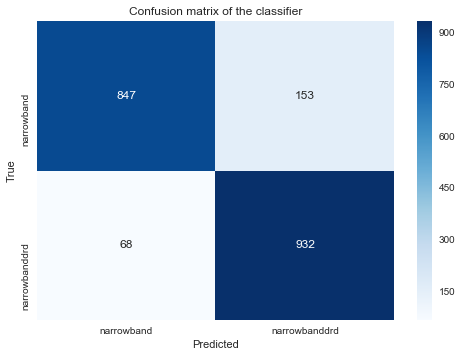

accuracy: 0.8895


In [358]:
#create a confusion matrix to sort the predictions and calculate accuracy
labels = ["narrowband", "narrowbanddrd"]
cm = confusion_matrix(results['class'], results['pred'], labels=labels) 
cm = pd.DataFrame(data=cm, columns=labels, index=labels)

fig = plt.figure()
sb.heatmap(cm, annot=True, fmt='g', cmap='Blues')

plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

correct = cm.values[0][0] + cm.values[1][1]
total = float(cm.values.sum())
accuracy = correct / total
print 'accuracy:', accuracy

# Analysis 

In this go around I was trying to distinguish Narrowband (N) from NarrowbandRD (RD) by fitting the bands to a linear regression. Since N is supposed to be linear and RD is supposed to be curved, their $R^2$ should be a telling feature. I did some light image processing on top of the seismogram processor - morphological closing of the bands, smoothing, adn skeletonizing. I also tried warping the images by stretching them out, thinking that the curves could be exaggerated, but that didn't yeild much. 

Once I got the skeletonized image, where the band was one pixel in width, I got the indeces of the band, scaled it so it would plot nicely, and fit it to a linaer regression. I then looped this over all the N/RD images, and tabulated the results. Above you can see a confusion matrix of the predictions and labels. We got a overall 86% accuracy, calculated as  $\frac{number Correct}{total}$. Narrowband false positive rate is driving the error, meaning that the RD curves may often appear linear; at least with this image processing.  

## Error Analysis

Below I label our predictions as True or False with the 'acc' column.

In [451]:
def labeler(x):
    if x['class'] == x['pred']:
        return True
    else:
        return False
    
results['acc'] = results.apply(labeler, axis=1)
results.head(3)

C:\Users\mohit\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,class,r2,adj_r2,slope,intercept,std,pred,acc
001b4fbd-bfbc-49e0-83a8-8b3c5b8b303d.dat,narrowbanddrd,0.946073,0.943999,30.822459,-1.234244,24.348177,narrowbanddrd,True
008f5103-bd62-4d4a-b4ba-7a2dcc0ba217.dat,narrowband,0.997530,0.997435,-3.185448,1.236958,61.930751,narrowband,True
009f6e84-1a0b-4b62-9d94-0ab9481ee6f9.dat,narrowband,0.998013,0.997937,34.954821,-1.229894,121.506943,narrowband,True


### Lets look at where narrowbanddrd was the true class, but we incorrectly predicted narrowband. 

$r^2$ should be high since these were thresholded. These lines should appear to be linear according to the algorithm. Lets dig through to see if there is something that the algo missed. 

In [467]:
#filter where narrowbanddrd was the true class
wrong_predictions = results[results['acc']==False] #wrong predictions 
correct_predictions = results[results['acc']==True] #correct predictions 

correct_predictions_NB = correct_predictions[correct_predictions['pred'] == 'narrowband'] #correctly predicted NB
correct_predictions_DRD = correct_predictions[correct_predictions['pred'] == 'narrowbanddrd'] #correctly predicted DRD
wrong_predictions_NB = wrong_predictions[wrong_predictions['pred'] == 'narrowband'] #incorrectly predicted NB
wrong_predictions_DRD = wrong_predictions[wrong_predictions['pred'] == 'narrowbanddrd'] #incorrectly predicted DRD

correct_predictions_DRD.describe()

,r2,adj_r2,slope,intercept,std
count,932.000000,932.000000,932.000000,932.000000,932.000000
mean,0.934920,0.932416,17.014302,-0.058614,95.465059
std,0.160486,0.166658,18.641054,1.198670,59.079517
min,0.001457,-0.036948,-9.218056,-1.363786,4.975624
25%,0.968862,0.967665,-2.128250,-1.231320,43.860808
50%,0.990502,0.990137,26.255614,-0.862170,92.812088
75%,0.994258,0.994037,34.307690,1.229387,137.657205
max,0.996148,0.996000,41.252226,1.335627,252.843365


Hmm. It looks like the standard deviations of the skeletonized curves are particularly high for these incorrect predictions. Scrolling up, when you compare them to the average of all the predictions, these incorrect ones are substantially higher. Lets quantify that. 

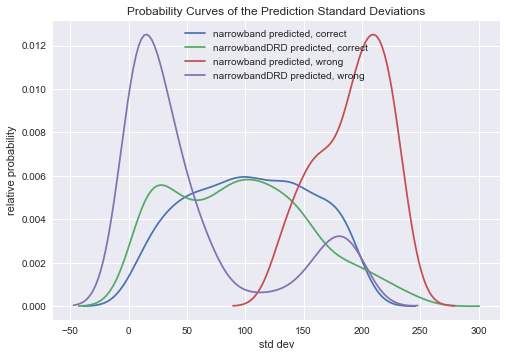

In [481]:
sb.kdeplot(correct_predictions_NB['std'])
sb.kdeplot(correct_predictions_DRD['std'])
sb.kdeplot(wrong_predictions_NB['std'])
sb.kdeplot(wrong_predictions_DRD['std'])

plt.legend(['narrowband predicted, correct',
            'narrowbandDRD predicted, correct',
            'narrowband predicted, wrong',
            'narrowbandDRD predicted, wrong'], loc='best')

plt.title('Probability Curves of the Prediction Standard Deviations')
plt.xlabel('std dev')
plt.ylabel('relative probability')
plt.show()

So the predictions errors seem to be related to the standard deviation of the curves from which the $r^2$ values are calulated. You can see that because our wrong predictions shift to the extremes, while the correct predictions are more normally distributed. Specfically, when narrowband is the true class, we can distinguish between our correct predictions (blue curve) and our wrong predictions (purple curve), based on the standard deviations. 

Let's get out of the relative probability space and look at number of occurences. Below is a histogram of that. If we predict narrowbandDRD based on an $r^2$ threshold, and the standard deviation is less than ~5 (the green peak), its likely that our prediction is wrong, and the true class is narrowband. We can put that conditional in our classifier.

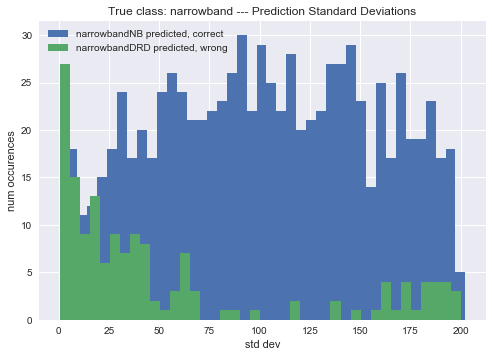

In [491]:
plt.hist(correct_predictions_NB['std'], bins=40, );
plt.hist(wrong_predictions_DRD['std'], bins=40);

plt.legend(['narrowbandNB predicted, correct',
            'narrowbandDRD predicted, wrong'])

plt.title('True class: narrowband --- Prediction Standard Deviations')
plt.xlabel('std dev')
plt.ylabel('num occurences')
plt.show()

C:\Users\mohit\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


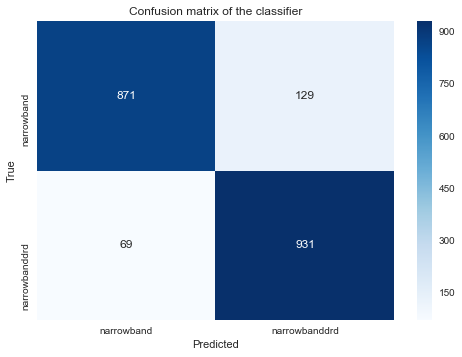

accuracy: 0.901


In [495]:
r2_threshold = 0.996 #intersection 
def r2_std_predictions(x):
    if x['adj_r2']>r2_threshold: 
        return 'narrowband'
    else: 
        if x['std']<5:     #add standard deviation conditional
            return 'narrowband'
        else:
            return 'narrowbanddrd'
    
results['pred'] = results.apply(r2_std_predictions, axis=1) #apply predictions 

#create a confusion matrix to sort the predictions and calculate accuracy
labels = ["narrowband", "narrowbanddrd"]
cm = confusion_matrix(results['class'], results['pred'], labels=labels) 
cm = pd.DataFrame(data=cm, columns=labels, index=labels)

fig = plt.figure()
sb.heatmap(cm, annot=True, fmt='g', cmap='Blues')

plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

correct = cm.values[0][0] + cm.values[1][1]
total = float(cm.values.sum())
accuracy = correct / total
print 'accuracy:', accuracy

A marginal boost of ~1.5% accuracy, but its something! We can see that our false narrowbandDRD predictiosn dropped from ~150 to 129, while false narrowband predictions only increased from 68 to 69. A good tradeoff. Any further ideas?

# Test code below 
might not work... but feel free to play with it if you think it is on to something. 


# Houghlines(P) line detection 

computer vision technique to find lines 

narrowbanddrd False


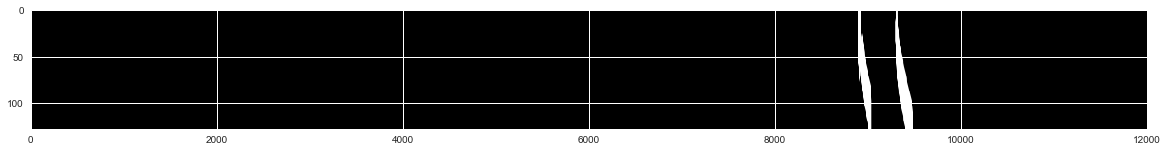

narrowband True


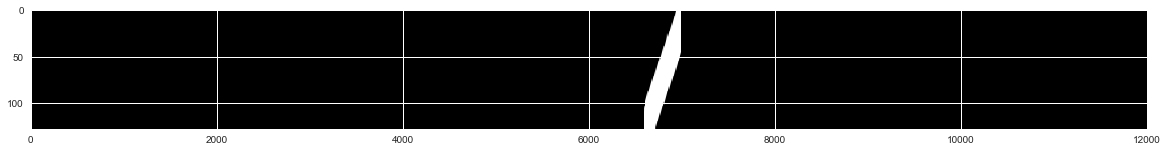

narrowband True


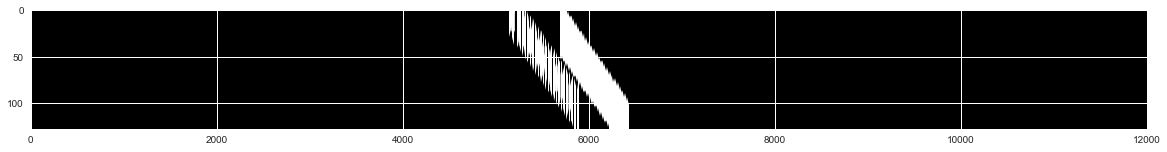

narrowband False


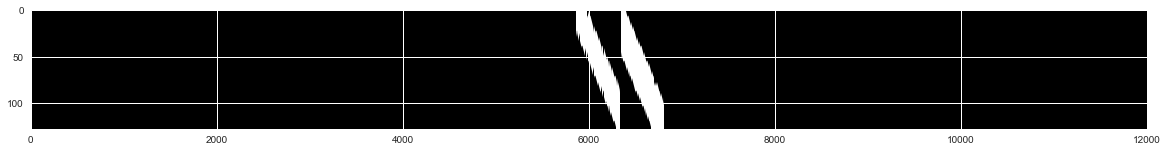

narrowband True


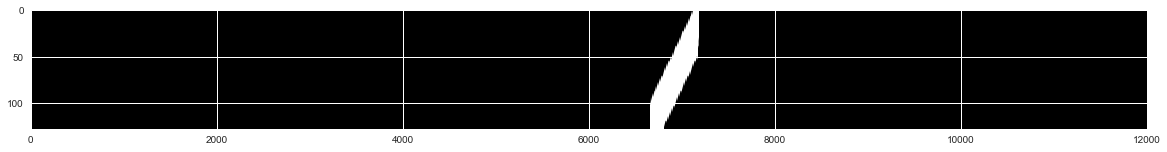

narrowband True


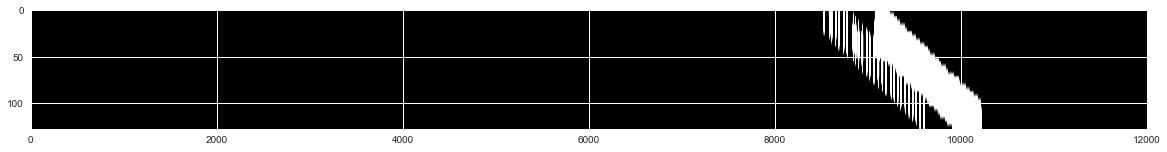

KeyboardInterrupt: 

In [311]:
correct = 0
plot_ = True 
data = np.empty((2,))

for image in basic4list: 
    full_label = label_csv.loc[image.split('.')[0]] #ID 
    class_ = full_label[1]
    if class_=='narrowbanddrd' or class_=='narrowband':
        linear = False #init as narrowbandrd 
        #print i, full_label #debug 

        spectrogram = seismogram(image)
        spectrogram = np.uint8(spectrogram)
        kernel = np.ones((11,11),np.uint8)
        spectrogram = cv2.morphologyEx(spectrogram, cv2.MORPH_CLOSE, kernel) #close holes 
           
        sobel_h = cv2.Sobel(spectrogram, cv2.CV_8UC1, 1, 0, ksize=7) #edge detector 
        sobel_v = cv2.Sobel(spectrogram, cv2.CV_8UC1, 0, 1, ksize=7) #edge detector 
        spectrogram = cv2.addWeighted(sobel_h, 0.5, sobel_v, 0.5, 0) #edge detector 
        
        spectrogram = cv2.GaussianBlur(spectrogram, (11,11), 0) #close gaps
        spectrogram[spectrogram > 0] = 255 #make binary

        
        gray = spectrogram.copy() #need gray scale for houglinesP detector 
        spectrogram = cv2.cvtColor(spectrogram, cv2.COLOR_GRAY2BGR) #color for plotting 
        
        lines = cv2.HoughLinesP(gray,
                                rho = 10,
                                theta = np.deg2rad(1),   
                                threshold = 100,
                                minLineLength = 200,
                                maxLineGap= 1)

        if lines is None: #if we did not find lines
            lines = []
            length = 0
            len_array = [0]
        else:  
            len_array = []
            for i in lines[:][:][:]:
                for x1,y1,x2,y2 in i:
#                     cv2.line(spectrogram,(x1,y1),(x2,y2),(255, 0, 255),2) 
                    length = np.sqrt((y2-y1)**2+(x2-x1)**2) #dist formula
                    len_array.append(length)
                    #print i, length
                    linear = True #for debugging
        print class_  , linear
        
        if plot_ == True:
            spectrogram = np.uint8(cv2.resize(spectrogram, (12000, 128)))
            fig, ax = plt.subplots()
            fig.set_size_inches(20, 20)
            cmap = plt.cm.get_cmap("Blues")
            ax.imshow(spectrogram, aspect = 10)
            plt.show()

        data = np.vstack((data, [class_, linear]))  #for analysis   
narr_res = pd.DataFrame(data=data, columns=['class', 'linear'], index=basic4list)

In [ ]:
d = pd.DataFrame(data)

n = (d.loc[d[0] == 'narrowband'])
nTP = (n.loc[n[1] == 'True'])
narrow_TP = nTP.shape[0]

nFP = (n.loc[n[1] == 'False'])
narrow_FP = nFP.shape[0]

nRD = (d.loc[d[0] == 'narrowbanddrd'])
nRDFN = (nRD.loc[nRD[1] == 'True'])
narrowrd_FN = nRDFN.shape[0]

nRDTN = (nRD.loc[nRD[1] == 'False'])
narrowrd_TN = nRDTN.shape[0]

In [455]:
print 'true positives', narrow_TP
print 'false negatives', narrow_FP
print 'false positives', narrowrd_FN
print 'true neg', narrowrd_TN

true positives 20
false negatives 13
false positives 4
true neg 24


In [456]:
(20+24)/(44+17)

0.7213114754098361